In [1]:
from numpy.lib import arraypad

In [2]:
import cv2
import numpy as np
from pylab import *
from PIL import Image
from matplotlib import pyplot as plot
%matplotlib inline
from skimage.morphology import skeletonize

In [3]:
IMG_SIZE = 28

# 一个数学计算式能够包含的最多字符个数
LARGEST_NUMBER_OF_SYMBOLS = 50

# 原图缩放比例
SCALSIZE = 1

In [4]:
def Perspective(img):
    rows, cols = img.shape[:2]
    pts1 = np.float32([[310, 175], [320, 100], [60, 45], [50, 120]])
    pts2 = np.float32([[0, 0], [0, 100], [270, 100], [270, 0]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img, M, (270, 100))
    return dst

In [5]:
#读取图片并将图片转化成二值图,返回原彩色图和二值图
def read_img_and_convert_to_binary(img):
    #读取待处理的图片
    original_img = img
    """
    image=Image.fromarray(original_img)
    imshow(image)
    show()
    """
    # print(original_img)
    original_img = Perspective(original_img)
    #将原图分辨率缩小SCALSIZE倍，减少计算复杂度
    original_img = cv2.resize(original_img,(np.int(original_img.shape[1]/SCALSIZE),np.int(original_img.shape[0]/SCALSIZE)), interpolation=cv2.INTER_AREA)
    #降噪
    blur = cv2.GaussianBlur(original_img, (3, 3), 0)
    #imshow(blur)
    #show()
    #将彩色图转化成灰度图
    img_gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
    #图片开（opening）处理，用来降噪，使图片中的字符边界更圆滑，没有皱褶
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)
    #imshow(opening)
    #show()
    kernel2 = np.ones((1,1), np.uint8)
    opening = cv2.dilate(opening, kernel2, iterations=1)
    #imshow(opening)
    #show()
    # Otsu's thresholding after Gaussian filtering
    # 采用otsu阈值法将灰度图转化成只有0和1的二值图
    blur = cv2.GaussianBlur(opening,(3,3),0)
    #imshow(blur)
    #show()
    #ret, binary_img = cv2.threshold(img_gray, 120, 1, cv2.THRESH_BINARY_INV)
    ret,binary_img = cv2.threshold(blur,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return original_img,binary_img

In [6]:
def extract_img(location,img,contour=None):
    x,y,w,h=location
    # 只提取轮廓内的字符
    if contour is None:
        extracted_img = img[y:y + h, x:x + w]
    else:
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        #imshow(mask)
        #show()
        img_after_masked = cv2.bitwise_and(mask, img)
        extracted_img = img_after_masked[y:y + h, x:x + w]
        #imshow(extracted_img)
        #show()
    # 将提取出的img归一化成IMG_SIZE*IMG_SIZE大小的二值图
    black = np.zeros((IMG_SIZE, IMG_SIZE), np.uint8)
    if (w > h):
        res = cv2.resize(extracted_img, (IMG_SIZE, (int)(h * IMG_SIZE / w)), interpolation=cv2.INTER_AREA)
        d = int(abs(res.shape[0] - res.shape[1]) / 2)
        black[d:res.shape[0] + d, 0:res.shape[1]] = res
    else:
        res = cv2.resize(extracted_img, ((int)(w * IMG_SIZE / h), IMG_SIZE), interpolation=cv2.INTER_AREA)
        d = int(abs(res.shape[0] - res.shape[1]) / 2)
        black[0:res.shape[0], d:res.shape[1] + d] = res
    extracted_img = skeletonize(black)
    #imshow(extracted_img)
    #show()
    extracted_img = np.logical_not(extracted_img)
    extracted_img.dtype = np.uint8
    extracted_img = cv2.GaussianBlur(extracted_img,(1,1),0)
    #imshow(extracted_img)
    #show()
    return extracted_img

In [7]:
def binary_img_segment(binary_img,original_img=None):
    # binary_img = skeletonize(binary_img)
    # plot.imshow( binary_img,cmap = 'gray', interpolation = 'bicubic')
    # plot.show()
    #寻找每一个字符的轮廓，使用cv2.RETR_EXTERNAL模式，表示只需要每一个字符最外面的轮廓
    img, contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE
    #cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    if len(contours) > LARGEST_NUMBER_OF_SYMBOLS:
        raise ValueError('symtem cannot interpret this image!')
    symbol_segment_location = []
    # 将每一个联通体，作为一个字符
    symbol_segment_list = []
    index = 1
    for contour in contours:
        location = cv2.boundingRect(contour)
        x, y, w, h = location
        if(w*h < 100):
            continue
        symbol_segment_location.append(location)
        # 只提取轮廓内的字符
        extracted_img = extract_img(location,img,contour)
        #kernel = np.ones((3, 3), np.uint8)
        #extracted_img = cv2.morphologyEx(extracted_img, cv2.MORPH_OPEN, kernel)
        #plot.imshow(extracted_img)
        #plot.show()
        symbol_segment_list.append(extracted_img)
        if len(original_img):
            cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 0, 255), 3)
        symbols=[]
        for i in range(len(symbol_segment_location)):
            symbols.append({'location':symbol_segment_location[i],'src_img':symbol_segment_list[i]})
        # 对字符按字符横坐标排序
        symbols.sort(key=lambda x:x['location'][0])
    #print(len(symbols))
    #print(symbols[0]['location'])
    #print(symbols[0]['src_img'])
    alphabet = []
    for i in range(length):
        alphabet.append({'location':symbols[-1-i]['location'],'src_img':symbols[-1-i]['src_img']})
    #print(alphabet)
    alphabet.sort(key=lambda x:x['location'][0])
    for i in range(len(alphabet)):
        plot.imshow(alphabet[i]['src_img'])
        plot.show()
    return alphabet

In [8]:
def normalize_matrix_value(symbol_segment_list):
    symbols_to_be_predicted = []
    for i in range(len(symbol_segment_list)):
        one = symbol_segment_list[i].reshape(IMG_SIZE * IMG_SIZE)
        t = np.ones((IMG_SIZE * IMG_SIZE), np.uint8)
        for j in range(IMG_SIZE * IMG_SIZE):
            if one[j] == True:
                t[j] = 255
            else:
                t[j] = 0
        symbols_to_be_predicted.append(np.array(t, np.float32))
    return np.array(symbols_to_be_predicted,np.float32)

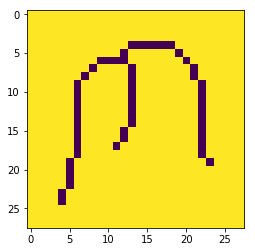

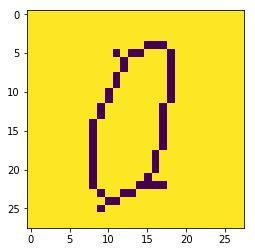

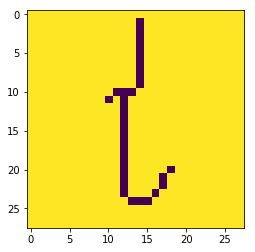

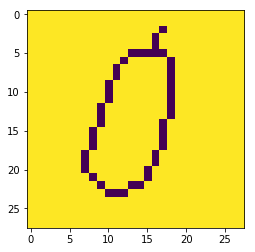

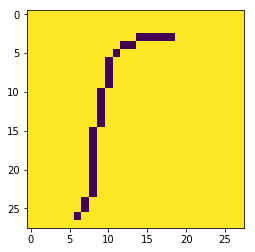

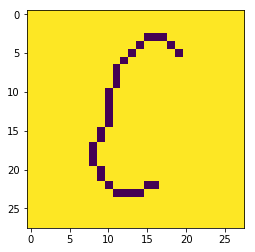

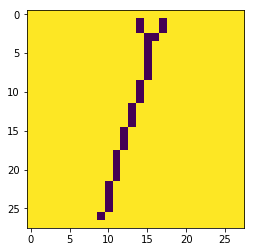

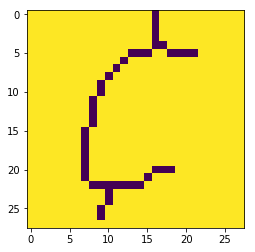

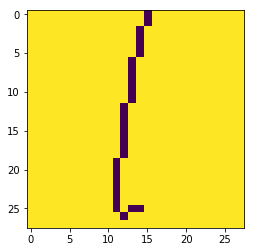

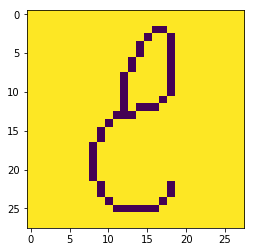

In [9]:
filename = 'wf.png'
img = cv2.imread(filename)
original_img, binary_img = read_img_and_convert_to_binary(img)
symbols = binary_img_segment(binary_img, original_img)
symbols_to_be_predicted = normalize_matrix_value([x['src_img'] for x in symbols])